In [1]:
import os
import random
import time

import gymnasium as gym

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical

import rl_utils

from stable_baselines3.common.atari_wrappers import (  # isort:skip
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

In [2]:
class Args:
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    capture_video: bool = False
    """whether to capture videos of the agent performances"""

    # Algorithm specific arguments
    env_id: str = "BreakoutNoFrameskip-v4"
    """the id of the environment"""
    total_timesteps: int = 10000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""

    # to be filled in runtime
    batch_size: int = 0
    """the batch size (computed in runtime)"""
    minibatch_size: int = 0
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""

args = Args()

In [3]:
def make_env(env_id):
    def thunk():
        env = gym.make(env_id)

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        return env

    return thunk

In [4]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)


    def get_value(self, x):
        # The range of input data is [0,255], but it should be divided by 255 to obtain the range [0,1].
        # It's very important , otherwise the first policy update will cause KL divergence explosion, which may be caused by the initialization method of the layers.

        return self.critic(self.network(x / 255.0))


    def get_action_and_value(self, x, action=None):
        # The range of input data is [0,255], but it should be divided by 255 to obtain the range [0,1].
        # It's very important , otherwise the first policy update will cause KL divergence explosion, which may be caused by the initialization method of the layers.
        # hidden is the output of self.network(). For probs, you could use Categorical(), and input for Categorical() is the output of self.actor()

        hidden = self.network(x / 255.0)
        actor_output = self.actor(hidden)
        probs = Categorical(logits=actor_output)

        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [5]:
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id) for i in range(args.num_envs)],
)


# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [6]:
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)


# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=args.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(args.num_envs).to(device)
return_list = []

In [7]:
for iteration in range(1, args.num_iterations + 1):
    # Annealing the rate
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            return_load = True
            for info in infos["final_info"]:
                if info and "episode" in info:
                    if return_load:
                        return_list.append(info['episode']['r'])
                    return_load = False
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")


    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)


            # Policy loss [pg_loss]
            pg_loss_1 = mb_advantages * ratio
            pg_loss_2 = mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.min(pg_loss_1, pg_loss_2).mean()
            # use gradient **ascent** -> negative for gradient **descent**
            pg_loss = -pg_loss


            # Value loss [v_loss]
            # v_loss = max{(V_{theta_t}-V_{target})^2, (clip(V_{theta_t},V_{theta_{t-1}}-epsilon,V_{theta_{t-1}}+epsilon)-V_{target})^2}
            # reference for the value's clip: MAPPO https://arxiv.org/pdf/2103.01955 P12
            # newvalue: (B, 1) -> (B), b_returns: (B)
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                old_value = b_values[mb_inds]
                newvalue_clipped = torch.clamp(newvalue, old_value - args.clip_coef, old_value + args.clip_coef)

                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_loss_clipped = (newvalue_clipped - b_returns[mb_inds]) ** 2
                v_loss = 0.5 * torch.max(v_loss_unclipped, v_loss_clipped).mean()

            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()


            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break


    print("SPS:", int(global_step / (time.time() - start_time)))

envs.close()

torch.save(agent.state_dict(), "ppo_Breakout.pth")

global_step=904, episodic_return=[0.]
SPS: 720
global_step=1144, episodic_return=[1.]
global_step=1648, episodic_return=[2.]
global_step=1672, episodic_return=[2.]
global_step=1808, episodic_return=[0.]
global_step=1872, episodic_return=[3.]
global_step=1904, episodic_return=[3.]
global_step=2016, episodic_return=[0.]
SPS: 956
global_step=2064, episodic_return=[3.]
global_step=2576, episodic_return=[0.]
global_step=2704, episodic_return=[5.]
global_step=2776, episodic_return=[0.]
global_step=2800, episodic_return=[1.]
SPS: 1069
global_step=3272, episodic_return=[1.]
global_step=3488, episodic_return=[2.]
global_step=3536, episodic_return=[2.]
global_step=3704, episodic_return=[1.]
global_step=3944, episodic_return=[1.]
global_step=3976, episodic_return=[1.]
SPS: 1139
global_step=4392, episodic_return=[0.]
global_step=4560, episodic_return=[1.]
global_step=4808, episodic_return=[1.]
global_step=4976, episodic_return=[1.]
SPS: 1199
global_step=5448, episodic_return=[2.]
global_step=5464,

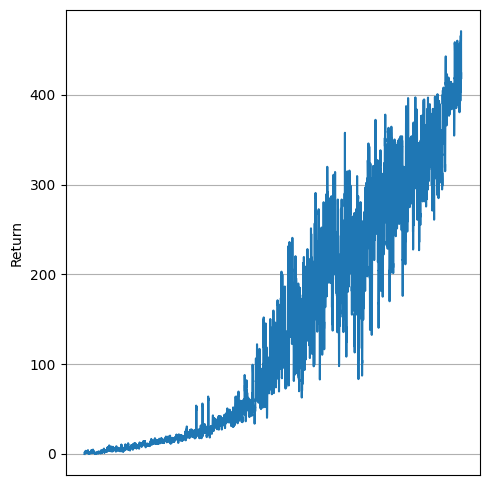

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

mv_return = rl_utils.moving_average(return_list, 9)

axes.plot(mv_return)
axes.set_ylabel("Return")
axes.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()
# The horizontal axis is not linear with respect to time